In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from astropy.wcs import WCS

from astroquery.sdss import SDSS

In [112]:
def extract_coords(SDSS_name):
    SDSS_name = SDSS_name[6:]
    
    decsign = ''
    if '+' in SDSS_name:
        decsign = '+'
    elif '-' in SDSS_name:
        decsign = '-'
    else:
        print("couldn't find declination sign")
        
    RA = SDSS_name[0:SDSS_name.index(decsign)]
    RA = RA[0:2] + 'h' + RA[2:4] + 'm' + RA[4:] + 's'
    
    Dec = SDSS_name[SDSS_name.index(decsign):]
    Dec = Dec[0:3] + 'd' + Dec[3:5] + 'm' + Dec[5:] + 's'
    
    return RA, Dec

In [ ]:
def rolling_quant(x, y, N_pix, stat=np.median):
    rm = np.zeros(len(x))
    for i in range(len(x)):
        if i < int(N_pix/2):
            rm[i] = stat(y[0:i+int(N_pix/2)])
        elif i <= len(x)-int(N_pix/2):
            rm[i] = stat(y[i-int(N_pix/2):i+int(N_pix/2)])
        else:  # i > len(x)-int(N_pix/2)
            rm[i] = stat(y[i-int(N_pix/2):-1])
    return rm

In [215]:
def remove_digits(string):
    digits = '0123456789'

    table = str.maketrans('', '', digits)
    return string.translate(table)


In [111]:
names = [
    "SDSS J013655.91+242546.0",
    "SDSS J090745.0+024507", 
    "SDSS J091301.00+305120.0",
    "SDSS J091759.42+672238.7",
    "SDSS J110557.45+093439.5",
    "SDSS J113312.12+010824.9",
    "SDSS J094214.04+200322.1",
    "SDSS J102137.08-005234.8",
    "SDSS J120337.85+180250.4"
]

name = names[0]

In [113]:
RA, Dec = extract_coords(name)
print(RA, Dec)

In [175]:
pos = coord.SkyCoord(RA + ' ' + Dec, frame='icrs')
print(pos,'\n\n')
search_radius = 1*u.arcmin

xid = SDSS.query_region(pos, spectro=True, radius=search_radius)

print("Query result\n", xid ,'\n\n')

sp = SDSS.get_spectra(matches=xid)

print("Get spectra result\n", np.shape(sp), type(sp), type(sp[0]))

for hdu in sp[0]:
    print(hdu)

<SkyCoord (ICRS): (ra, dec) in deg
    (24.23295833, 24.42944444)> 


Query result
        ra              dec        ...      specobjid      run2d
---------------- ---------------- ... ------------------- -----
24.2329283575442 24.4294367064923 ... 2301453814613436416    26 


Get spectra result
 (1, 12) <class 'list'> <class 'astropy.io.fits.hdu.hdulist.HDUList'>


In [180]:
# print(sp[0].info())
# sp[0][0].header

In [314]:
df = pd.DataFrame(sp[0][1].data)

star_wavelengths = 10**df['loglam'].to_numpy()  # * u.Angstrom
star_flux = df['flux'].to_numpy() #* 1e-17  # *u.erg/u.cm**2/u.s/u.Angstrom


In [319]:
star_continuum = rolling_quant(star_wavelengths, star_flux, 100, lambda x: np.percentile(x, 90))
star_normed = star_flux/star_continuum

# Npixels = 100
# plt.figure(figsize=(15,7))
# plt.plot(wavelengths, flux, lw=0.5)
# plt.plot(wavelengths, rolling_quant(wavelengths.value, flux.value, Npixels, lambda x: np.percentile(x, 90)), lw=1, c='purple', label='Rolling Percentile Continuum N=1000')
# plt.xlabel("Wavelength (Angstrom)")
# plt.ylabel("flux")
# plt.legend()
# plt.show()

# plt.figure(figsize=(15,7))
# plt.plot(wavelengths, flux, lw=0.5)
# plt.plot(wavelengths, rolling_quant(wavelengths.value, flux.value, Npixels, lambda x: np.percentile(x, 90)), lw=1, c='purple', label='Rolling Percentile Continuum N=1000')
# plt.xlabel("Wavelength (Angstrom)")
# plt.ylabel("flux")
# plt.xlim([4200,4400])
# plt.legend()
# plt.show()

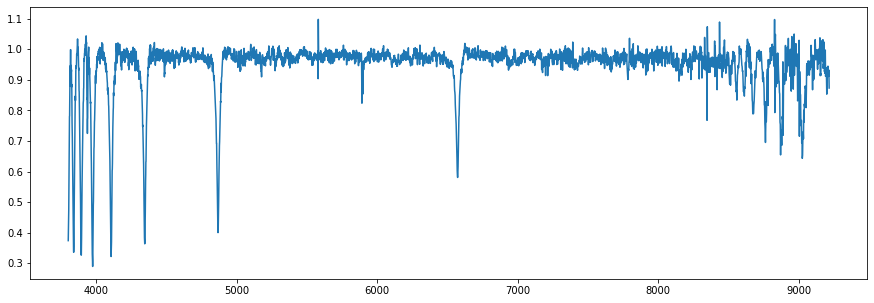

In [320]:
plt.figure(figsize=(15,5))
# plt.plot(wavelengths, star_flux)
plt.plot(star_wavelengths, star_normed)
plt.plot()
plt.show()

In [321]:
spec_type = remove_digits(sp[0][2].header['TFORM1'])

template = SDSS.get_spectral_template(f'star_{spec_type}')

# borrowed from https://github.com/rpmunoz/PentaUC
spec_hdr = template[0][0].header
spec_dat = template[0][0].data
wcs = WCS(spec_hdr)  

index = np.arange(spec_hdr['NAXIS1'])
tmpl_wavelengths = 10**wcs.wcs_pix2world(index, np.zeros(len(index)), 0)[0]
tmpl_flux = spec_dat[0]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a string value was expected. [astropy.wcs.wcs]


In [322]:
tmpl_continuum = rolling_quant(tmpl_wavelengths, tmpl_flux, 100, lambda x: np.percentile(x, 90))
tmpl_normed = tmpl_flux/tmpl_continuum


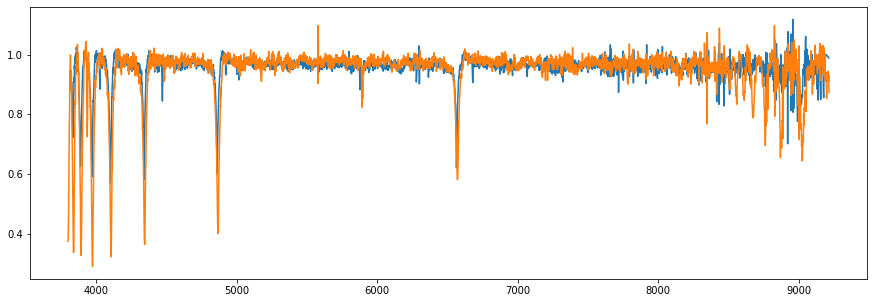

In [324]:
plt.figure(figsize=(15,5))
plt.plot(tmpl_wavelengths, tmpl_normed)
plt.plot(star_wavelengths, star_normed)
plt.plot()
plt.show()

In [326]:
def CCF(shift, spec_wls, spec_dat, tmpl_wls, tmpl_dat):
    shifted_data = np.interp(spec_wls, doppler_shift(tmpl_wls, shift), tmpl_dat)
    return np.correlate(shifted_data, spec_dat)[0]

In [367]:
def doppler_shift(wavelens, radvel):
    # radvel in km/s
    return wavelens*(1+(radvel/(3e5*u.km/u.s)).to(u.dimensionless_unscaled))

In [376]:
shifts = np.linspace(-1000, 1000, int(1e5))*u.km/u.s
XCs = [CCF(shift, star_wavelengths, star_normed, tmpl_wavelengths, tmpl_normed) for shift in shifts]    

RV = shifts[np.argmax(XCs)]

SN = np.median((spec_hdr['SN_G'], spec_hdr['SN_I'], spec_hdr['SN_R']))
sig_RV = 500/SN*u.m/u.s

print(f"RV = {RV:.2e} +/- {sig_RV.to(u.km/u.s):.2e}")

RV = 2.76e+02 km / s +/- 5.64e-03 km / s


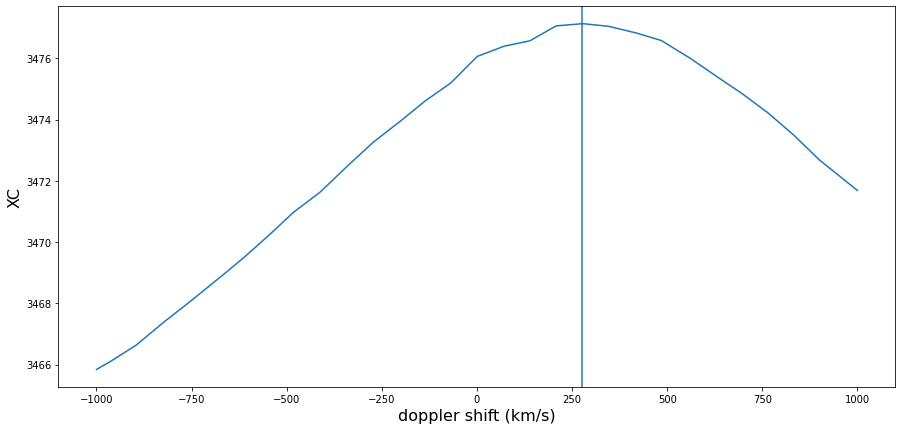

In [377]:
plt.figure(figsize=(15,7))
plt.plot(shifts, XCs)
plt.axvline(RV.value)
plt.xlabel('doppler shift (km/s)', size=16)
plt.ylabel('XC', size=16)
plt.show()

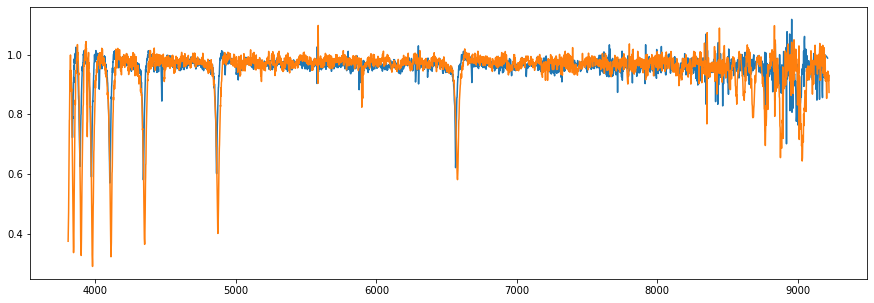

In [378]:
plt.figure(figsize=(15,5))
plt.plot(tmpl_wavelengths, tmpl_normed)
plt.plot(doppler_shift(star_wavelengths, RV), star_normed)
plt.plot()
plt.show()